In [1]:
from pystan import StanModel
n_jobs = 4
import pandas as pd
import seaborn as sns
sns.set_color_codes()
import pickle
%pylab inline
from scipy.stats import norm, truncnorm, multivariate_normal, lognorm, t

Populating the interactive namespace from numpy and matplotlib


- Make into a proper module somehow?

In [2]:
import pickle
models = pickle.load(open('model.pkl', 'rb'))

In [3]:
model_name = 'improvement~N(mu*beta,sigma)'
models[model_name] = {}

models[model_name]['code'] = """
functions{
    
    real lower_truncated_normal_lpdf_vector(vector x, vector mu, vector sigma, real lower_bound) {
            return(normal_lpdf(x | mu, sigma) - normal_lccdf(lower_bound | mu, sigma));
    }

}

data {
    int N_technologies;
    int N_updates;
    vector[N_updates] observed_updates;
    int updates_tech_inds[N_updates];
    
    int tech_starts[N_technologies];
    int tech_stops[N_technologies];

    real first_observation_value[N_technologies];
    int first_observation[N_technologies];
    int last_observation[N_technologies];  
    int backcast_to_observation;
    int forecast_to_observation;
    
    
    int N_gaps;
    real gap_heights[N_gaps];
    int gap_lengths[N_gaps];
    
    int N_gap_updates;

    int N_predictors;
    matrix[N_updates, N_predictors] update_predictors; 
    
    matrix[forecast_to_observation, N_predictors] predictors[N_technologies]; //all predictor data, for forecasting
    
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
    
    real beta_prior_location;
    real beta_prior_scale;

    int<lower = 0, upper = 1> run_estimation; // a switch to evaluate the likelihood

}

  
parameters {
    vector<lower = 0, upper = 1>[N_gap_updates] gap_updates_raw; // inferred updates between first and last observations

    
    vector<lower = 0>[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
    matrix[N_technologies, N_predictors] beta;
    
}

transformed parameters {
    //vector[N_time_steps_to_fit] Y_latent; // value each time period
    vector<lower = 0>[N_gap_updates] gap_updates;
    vector<lower = 0>[N_updates] updates;
    
    {
    int latest_gap_position;
    latest_gap_position = 1;
    for(i in 1:N_gaps){
        gap_updates[latest_gap_position:latest_gap_position+gap_lengths[i]] = 
        gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]/
        sum(gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]) 
        * gap_heights[i];
        latest_gap_position = latest_gap_position + gap_lengths[i] + 1;
    }
    }
    
    {
    int gap_ind;
    gap_ind = 1;
    for (u in 1:N_updates){
        if (observed_updates[u]!=-999.0){
            updates[u] = observed_updates[u];
        }
        else{
            updates[u] = gap_updates[gap_ind];
            gap_ind = gap_ind + 1;
        }
        
    }
    }
}

model {
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    for (i in 1:rows(beta)){
        beta[i] ~ normal(beta_prior_location, beta_prior_scale);
    }
    

    if(run_estimation==1){
        target += lower_truncated_normal_lpdf_vector(updates, 
                                                    mu[updates_tech_inds].*
                                                    exp(rows_dot_product(beta[updates_tech_inds], update_predictors)), 
                                                    sigma[updates_tech_inds], 0.0);
    }

}

generated quantities {

    matrix[forecast_to_observation,N_technologies] Y_sim;
    
    {
    int updates_ind;
    updates_ind = 1;
    for (tech in 1:N_technologies){
        Y_sim[first_observation[tech], tech] = first_observation_value[tech];
        Y_sim[first_observation[tech]+1:
              first_observation[tech]+1+tech_stops[tech]-tech_starts[tech],
              tech] = cumulative_sum(updates[tech_starts[tech]:tech_stops[tech]]) 
                      + rep_vector(first_observation_value[tech], tech_stops[tech]-tech_starts[tech]+1);
    }
    }

    {
    real update_size;
    //Fill out future data points
    for (tech in 1:N_technologies){
        for(t in last_observation[tech]+1:forecast_to_observation){
            // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
            // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
            update_size = -1.0;  
            while (update_size<0){
                update_size = normal_rng(mu[tech].*exp(beta[tech]*predictors[tech][t]'),sigma[tech]);
            }
            Y_sim[t, tech] = update_size + Y_sim[t-1, tech];
        }
    }
    }

}
"""

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['model_parameters'] = ['mu', 'sigma', 'beta']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    'beta_prior_location': 0,
    'beta_prior_scale': 1,    
    }

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_735b9ec8ccaa22bac07703ecf2ec2f23 NOW.


In [4]:
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    'beta_prior_location': 0,
    'beta_prior_scale': 1,    
    }

n_technologies = 30
n_updates = 1
forecast_to_observation = 101
n_predictors = 1
predictors = ones((n_technologies,forecast_to_observation,n_predictors))

stan_data = {
    'N_technologies': n_technologies,
     'N_updates': n_technologies*n_updates,
     'observed_updates': rand(n_technologies*n_updates),
     'updates_tech_inds': [i+1 for i in arange(n_technologies) for j in arange(n_updates)],
     'tech_starts': [1+n_updates*i for i in arange(n_technologies)],
     'tech_stops': [n_updates*(i+1) for i in arange(n_technologies)],
     'N_gaps': 0,
     'gap_heights': array([],dtype='int'),
     'gap_lengths': array([],dtype='int'),
     'N_gap_updates': 0,
    'first_observation_value': zeros(n_technologies).astype('int'),                 
    'first_observation': ones(n_technologies).astype('int'),
    'last_observation': ones(n_technologies).astype('int')*n_updates,
    'backcast_to_observation': 1,
    'forecast_to_observation': forecast_to_observation,
    'N_predictors': n_predictors,
    'update_predictors': array([predictors[:,:n_updates,i].ravel(order='F') for i in arange(n_predictors)]).T,
    'predictors': predictors,
    'run_estimation': 0
}
stan_data = {**stan_data, **models[model_name]['parameter_priors']} 
model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)

draw = 21
Y_sim = model_fit['Y_sim'][draw]
simulated_parameters = {}
for parameter in models[model_name]['model_parameters']:
    simulated_parameters[parameter] = model_fit[parameter][draw]

In [5]:
stan_data = {
    'N_technologies': n_technologies,
     'N_updates': n_technologies*(forecast_to_observation-n_updates-1),
     'observed_updates': diff(Y_sim[n_updates:],axis=0).ravel(order='F'),
     'updates_tech_inds': [i+1 for i in arange(n_technologies) for j in arange(forecast_to_observation-n_updates-1)],
     'tech_starts': [1+(forecast_to_observation-n_updates-1)*i for i in arange(n_technologies)],
     'tech_stops': [(forecast_to_observation-n_updates-1)*(i+1) for i in arange(n_technologies)],
     'N_gaps': 0,
     'gap_heights': array([],dtype='int'),
     'gap_lengths': array([],dtype='int'),
     'N_gap_updates': 0,
    'first_observation_value': Y_sim[n_updates],                 
    'first_observation': ones(n_technologies).astype('int'),
    'last_observation': ones(n_technologies).astype('int')*(forecast_to_observation-n_updates-1),
    'backcast_to_observation': 1,
    'forecast_to_observation': forecast_to_observation-n_updates,
    'N_predictors': n_predictors,
    'update_predictors': array([predictors[:,n_updates:-1, i].ravel(order='F') for i in arange(n_predictors)]).T, #Unsure about the -1
    'predictors': predictors[:,n_updates:],
    'run_estimation': 1
}
stan_data = {**stan_data, **models[model_name]['parameter_priors']} 
model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


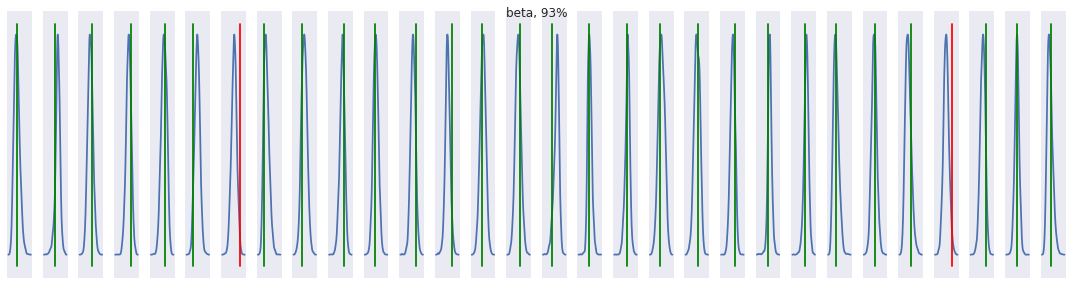

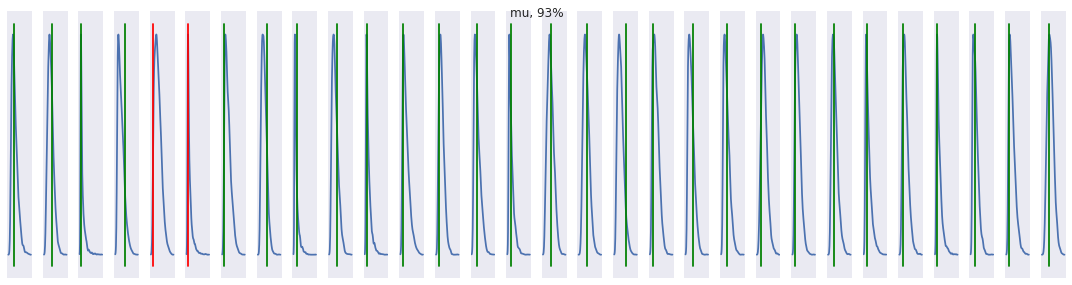

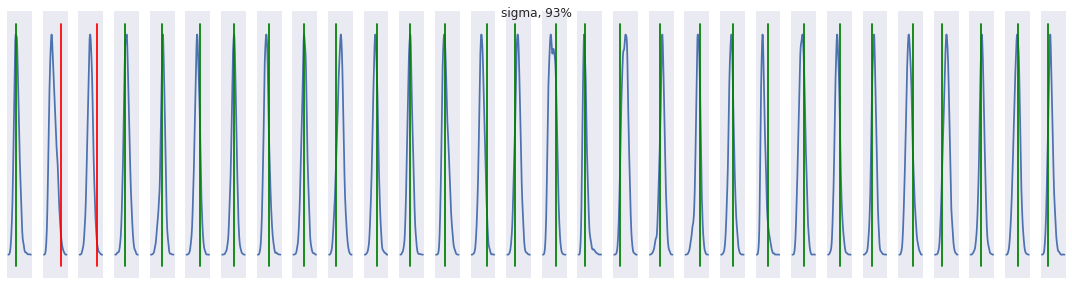

In [6]:
for parameter in simulated_parameters:
    df = pd.DataFrame(squeeze(model_fit[parameter]))
    n_params = df.shape[1]
    fig = figure(figsize=(15,4))
    this_ax = 0
    in_95CI_sum = 0
    for i in arange(n_params):
        this_ax += 1
        ax = fig.add_subplot(1, n_params, this_ax)
        sns.kdeplot(df[i],ax=ax, legend=False)
        true_parameter = simulated_parameters[parameter][i]
        in_95CI = true_parameter<percentile(df[i], 97.5) and true_parameter>percentile(df[i], 2.5)
        if in_95CI:
            color='green'
            in_95CI_sum += 1
        else:
            color='red'
        ax.plot((true_parameter,true_parameter),
                ylim(), color=color)
        yticks([])
        xticks([])
    
    suptitle("%s, %.0f%%"%(parameter, 100*in_95CI_sum/n_params))
    tight_layout()

In [ ]:
# def fit_with_model(model_name,
#                    model_code=None, 
#                    model_parameters=None,
#                    parameter_priors=None, 
#                    time_series=empirical_time_series,
#                    technology_models_fit_parameters=technology_models_fit_parameters,
#                    print_output=True,
#                   predictors=None):
    
#     if model_code is None:
#         model_code = models[model_name]['code']
#     if model_parameters is None:
#         model_parameters = models[model_name]['model_parameters']
#     if parameter_priors is None:
#         parameter_priors = models[model_name]['parameter_priors']
    
#     technology_models_fit_parameters[model_name] = pd.DataFrame(index=model_parameters, 
#                                                                 columns=time_series.columns
#                                                                 )

#     stan_data = stan_data_from_Y(time_series, predictors=predictors)
#     stan_data = {**stan_data, **parameter_priors} 

#     ###
#     model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)

#     if print_output:
#         print(_print_stanfit(model_fit, model_parameters))
#     for parameter in model_parameters:
#         technology_models_fit_parameters[model_name].ix[parameter] = model_fit[parameter].mean(axis=0)

In [7]:
data_directory = '../data/'

empirical_data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
empirical_data = empirical_data.reindex(arange(empirical_data.index[0],empirical_data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')

target_tech_names = metadata.loc[(metadata['Domain'].notnull()), 'Name']
empirical_time_series = log(empirical_data[target_tech_names])

valid_time_series = sum(~empirical_time_series.loc[1976:].isnull())>3
valid_domains = metadata.set_index('Name').loc[valid_time_series.index[valid_time_series]]['Domain'].unique()

print("Number of valid domains: %i"%valid_domains.size)

Number of valid domains: 21


In [8]:
patent_data_directory = '/home/jeffrey_alstott/technoinnovation/patent_centralities/data/'

patents = pd.read_hdf(patent_data_directory+'patents.h5', 'df')
citations = pd.read_hdf(patent_data_directory+'citations.h5', 'df')

citations['Citation_Lag'] = citations['Year_Citing_Patent']-citations['Year_Cited_Patent']
backward_citations = citations.groupby('Citing_Patent')

patents['Citations_Backward_N'] = citations.groupby('Citing_Patent').size()[patents['patent_number']].values
patents['Citations_Backward_Age_Mean'] = citations.groupby('Citing_Patent')['Citation_Lag'].mean()[patents['patent_number']].values
patents['Citations_Backward_Age_STD'] = citations.groupby('Citing_Patent')['Citation_Lag'].std()[patents['patent_number']].values

patent_centralities_z = pd.read_hdf(patent_data_directory+'centralities/summary_statistics.h5', 'empirical_z_scores_USPC')
patent_centralities_z.drop('filing_year', axis=1, inplace=True)
patents = patents.merge(patent_centralities_z, on='patent_number')

patents_percentile_by_year = patents.copy()
for col in patents.columns:
    if col in ['filing_year', 'patent_number', 'Class']:
        continue
    patents_percentile_by_year[col] = patents.groupby('filing_year')[col].rank(pct=True)

patents_percentile_by_year.set_index('patent_number', inplace=True)

In [9]:
patent_domains = pd.read_csv(data_directory+'PATENT_SET_DOMAINS.csv', index_col=0)
def floatify(x):
    from numpy import nan
    try:
        return float(x)
    except ValueError:
        return nan
patent_domains['patent_id'] = patent_domains['patent_id'].apply(floatify)
patent_domains = patent_domains.dropna()
domains = patent_domains['Domain'].unique() 

In [10]:
from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer
    
def plot_time_series_inference(model_fit, var='Y_sim', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,:,ind]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)
    
from scipy.stats import percentileofscore
def portion_of_data_within_CI(model_fit, parameter, data, lower=2.5, upper=97.5):
    if data.ndim<2:
        a = array((list(map(percentileofscore, model_fit[parameter].T, data))))
        return mean((lower<a)*(a<upper))
    else:
        values = empty(data.shape[1])
        for i in range(data.shape[1]):
            a = array((list(map(percentileofscore, model_fit[parameter][:,i], data.iloc[:,i]))))
            values[i]=nanmean((lower<a)*(a<upper))
        return values
    
def portion_of_forecast_within_CI(model_fit, forecast, data, 
                                  forecast_start_ind, forecast_stop_ind,
                                  lower=2.5, upper=97.5):
    u = percentile(model_fit[forecast],upper,axis=0)
    l = percentile(model_fit[forecast],lower,axis=0)
    return nanmean((l[forecast_start_ind:forecast_stop_ind]<data[forecast_start_ind:forecast_stop_ind])*
                   (data[forecast_start_ind:forecast_stop_ind]<u[forecast_start_ind:forecast_stop_ind]),
                  axis=0)

def calculate_Omega_from_L_Omega(model_fit):
    f = lambda x,y: matrix(x)*matrix(y)
    return list(map(f, model_fit['L_Omega'], transpose(model_fit['L_Omega'],[0,2,1])))

def calculate_covariance_from_L_Omega_and_tau(model_fit):
    Omegas = calculate_Omega_from_L_Omega(model_fit)
    f = lambda tau, Omega: diag(tau)*Omega*diag(tau)
    return list(map(f, model_fit['tau'], Omegas))

In [11]:
def stan_data_from_Y(Y,
                     backcast_to_observation=1,
                    forecast_to_observation=None,
                    predictors=None):
    Y = Y.copy()
    Y.index = arange(Y.shape[0])
    Y.columns = arange(Y.shape[1])
    N_time_periods, N_technologies = Y.shape
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    first_observation_value = Y.apply(lambda x: x[x.first_valid_index()])

    if forecast_to_observation is None:
        forecast_to_observation = Y.shape[0]+1
    
    updates_vector = []
    tech_starts = []
    tech_stops = []
    updates_tech_inds = []
    for i in range(N_technologies):
        tech_starts.append(len(updates_vector))
        this_updates = Y.iloc[first_observation[i]:last_observation[i]+1,i].diff()[1:].values.tolist()
        updates_vector += this_updates
        tech_stops.append(len(updates_vector))
        updates_tech_inds+=[i for j in this_updates]
    updates_vector = pd.Series(updates_vector)
    N_updates = len(updates_vector)
    N_gap_updates = {}
    gap_starts = {}
    gap_stops = {}
    gap_lengths = {}
    gap_heights = {}
    gap_time_steps = {}
    gap_techs = {}
    for i in Y.columns:
        gap_inds = Y.iloc[first_observation[i]:last_observation[i]+1,i].isnull().astype('int')
        d = gap_inds.diff()
        gap_starts[i] = d[d==1].index.values.astype('int')
        gap_stops[i] = d[d==-1].index.values.astype('int')
        gap_lengths[i] = gap_stops[i]-gap_starts[i]
        N_gap_updates[i] = gap_lengths[i]+1
        gap_heights[i] = Y.iloc[gap_stops[i],i].values - Y.iloc[gap_starts[i]-1,i].values
        gap_time_steps[i] = gap_inds[gap_inds==1].index.values

    gap_heights_vector = []
    gap_lengths_vector = []
    for i in Y.columns:
        gap_heights_vector+=gap_heights[i].tolist()
        gap_lengths_vector+=gap_lengths[i].tolist()

    stan_data = {'N_technologies': N_technologies,
                 'N_updates': N_updates,
                 'observed_updates': updates_vector.fillna(-999.0),
                 'updates_tech_inds': array(updates_tech_inds).astype('int')+1,
                 'tech_starts': array(tech_starts).astype('int')+1,
                 'tech_stops': array(tech_stops).astype('int'),
                 'N_gaps': len(gap_heights_vector),
                 'gap_heights': gap_heights_vector,
                 'gap_lengths': array(gap_lengths_vector).astype('int'),
                 'N_gap_updates': sum([sum(N_gap_updates[i]) for i in N_gap_updates]),
                'first_observation_value': first_observation_value,                 
                'first_observation': first_observation.astype('int')+1,
                'last_observation': last_observation.astype('int')+1,
                'backcast_to_observation': backcast_to_observation,
                'forecast_to_observation': forecast_to_observation,
                 'run_estimation': 1
                }
    if predictors is not None:
        if type(predictors) == pd.core.frame.DataFrame:
            predictors = pd.Panel({0: predictors})
            predictors = predictors.transpose(2,1,0)
            # first techs, then time, then predictors
        
        predictors.minor_index = arange(predictors.shape[2])
        predictors.major_index = arange(Y.shape[0])
        predictors.items = arange(Y.shape[1])
#         all_predictors_vector = []
#         update_predictors = []
#         for i in range(N_technologies):
#             this_predictors_vector = []
# #             for i in Y.columns:
#                 # first techs, then time, then predictors
#             this_predictors_vector += predictors.iloc[i, 
#                                                       first_observation[i]:last_observation[i]-1,
#                                                       :].values.T.tolist()
# #                 update_predictors += predictors.iloc[i,
# #                                                     first_observation[i]:last_observation[i]-1,
# #                                                     :].values.ravel().tolist()
#             print(this_predictors_vector)
#             all_predictors_vector.append(this_predictors_vector)
        update_predictors = concatenate([predictors.iloc[i, 
                                                      first_observation[i]:last_observation[i],
                                                      :].values for i in range(N_technologies)])
        stan_data = {**stan_data, 
                     **{'N_predictors': predictors.shape[2],
                       'update_predictors': update_predictors, #array(all_predictors_vector),
                       'predictors': predictors.iloc[:,:forecast_to_observation].values}
                    } 
    return stan_data

In [12]:
# performance_technology_forecast_models_Y_sim = {}
performance_technology_forecast_models_95CI = {}
# performance_technology_forecast_models_parameters = {}
performance_technology_forecast_models_log_pd = {}
performance_technology_forecast_models_fit = {}

# price_technology_forecast_models_Y_sim = {}
price_technology_forecast_models_95CI = {}
# price_technology_forecast_models_parameters = {}
price_technology_forecast_models_log_pd = {}
price_technology_forecast_models_fit = {}

In [13]:
from scipy.stats import gaussian_kde
def predict_with_model(model_name, 
                       time_series,
                       predictors,
                       training_years,
                       horizons,
                       time_series_from_each_time_period,
                       technology_forecast_models_log_pd,
#                        technology_forecast_models_parameters,
                       technology_forecast_models_95CI,
#                        technology_forecast_models_Y_sim,
                       technology_forecast_models_fit, 
                       target_tech_names,
                       model_code=None, 
                       model_parameters=None,
                       parameter_priors=None,
                       print_output=True):
    
    if model_code is None:
        model_code = models[model_name]['code']
    if model_parameters is None:
        model_parameters = models[model_name]['model_parameters']
    if parameter_priors is None:
        parameter_priors = models[model_name]['parameter_priors']
    
    technology_forecast_models_log_pd[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    technology_forecast_models_95CI[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    
#     technology_forecast_models_parameters[model_name] = pd.Panel(items=target_tech_names,
#              major_axis=model_parameters, 
#              minor_axis=training_years)
#     technology_forecast_models_Y_sim[model_name] = {}
    technology_forecast_models_fit[model_name] = {}
    
    for training_year in training_years:
        print(training_year)

        forecast_start_ind = int(training_year-first_year)
        time_series_from_time_period = time_series_from_each_time_period[training_year]
        n_time_series_from_time_period = len(time_series_from_time_period)
        


        if predictors is not None:
            stan_data = stan_data_from_Y(time_series.loc[:training_year, 
                                                        time_series_from_time_period],
                                        forecast_to_observation=time_series.shape[0],
                                        predictors=predictors[time_series_from_time_period])
        else:
            stan_data = stan_data_from_Y(time_series.loc[:training_year, 
                                                    time_series_from_time_period],
                                    forecast_to_observation=time_series.shape[0])
        stan_data = {**stan_data, **parameter_priors} 

        ###
        model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)
        Y_sim = model_fit['Y_sim']
#         technology_forecast_models_Y_sim[model_name][training_year] = Y_sim
        
        if print_output:
            print(_print_stanfit(model_fit, model_parameters))
            
        technology_forecast_models_fit[model_name] = model_fit
#         for parameter in model_parameters:
#             technology_forecast_models_parameters[model_name]
#             p = model_fit[parameter].mean(axis=0)

#             if type(p)==numpy.ndarray:
#                 for i in range(len(p)):
#                     technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
#                                                         parameter+'_%i'%i,
#                                                         training_year] = p[i]
#             else:        
#                 technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
#                                                             parameter,
#                                                             training_year] = p

        for horizon in horizons:
            if horizon=='all':
                forecast_stop_ind = time_series.shape[0]
            else:
                forecast_stop_ind = horizon+forecast_start_ind
            
            times, techs = where(time_series[time_series_from_time_period].notnull())
            techs_to_forecast = techs[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            times_to_forecast = times[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            lpd = list(map(lambda x,y: x.logpdf(y)[0], 
                           map(gaussian_kde, Y_sim[:,times_to_forecast,techs_to_forecast].T), 
                           time_series[time_series_from_time_period].values[times_to_forecast, techs_to_forecast]))

            lpd = array(lpd)
            lpd[lpd==-inf] = log(finfo('d').tiny)
            lpd = pd.groupby(pd.Series(lpd),techs_to_forecast).sum()
            lpd = lpd.reindex(arange(len(time_series_from_time_period)))
            lpd.index = time_series_from_time_period
            technology_forecast_models_log_pd[model_name].ix[time_series_from_time_period,
                                                                 horizon,training_year] = lpd
            CI95 = portion_of_forecast_within_CI(model_fit, 'Y_sim', 
                                                 time_series[time_series_from_time_period].values, 
                                                 forecast_start_ind, 
                                                 forecast_stop_ind)
            technology_forecast_models_95CI[model_name].ix[time_series_from_time_period,
                                                           horizon,training_year] = CI95

In [14]:
training_years = arange(1990,2010,5)
horizons = [5]

target_tech_names = metadata.ix[(metadata['Type']=='Performance')*(~metadata['Domain'].isnull()), 'Name']
print("%i technologies"%target_tech_names.shape[0])

target_empirical_time_series = log(empirical_data[target_tech_names])
### Select only those time series that have at least 3 data points from before the training year
min_data_points_to_include_time_series = 3

first_year = 1981
target_empirical_time_series = target_empirical_time_series.loc[first_year:]
performance_time_series_from_each_time_period = {}

for training_year in training_years:
    print(training_year)
    performance_time_series_from_time_period = target_empirical_time_series.columns[target_empirical_time_series.loc[first_year:training_year].notnull().sum(axis=0)>=min_data_points_to_include_time_series]
    performance_time_series_from_each_time_period[training_year] = performance_time_series_from_time_period

34 technologies
1990
1995
2000
2005


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [15]:
n_forecasts = 0
for training_year in training_years:
    print(training_year)
    n = target_empirical_time_series.ix[training_year:training_year+5, 
                                    performance_time_series_from_each_time_period[training_year]].notnull().sum().sum()
    print(n)
    n_forecasts += n
print("%i total forecasts"%n_forecasts)

1990
36
1995
59
2000
52
2005
16
163 total forecasts


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [22]:
for model_name in ['improvement~N(mu,sigma)', 
                  ]:
    print(model_name)
    predict_with_model(model_name,
                       time_series=target_empirical_time_series,
                       training_years=training_years, horizons=horizons,
                       time_series_from_each_time_period=performance_time_series_from_each_time_period,
                       technology_forecast_models_log_pd=performance_technology_forecast_models_log_pd,
#                        technology_forecast_models_parameters=performance_technology_forecast_models_parameters,
                       technology_forecast_models_95CI=performance_technology_forecast_models_95CI,
#                        technology_forecast_models_Y_sim=performance_technology_forecast_models_Y_sim,
                       technology_forecast_models_fit=performance_technology_forecast_models_fit,
                       target_tech_names=target_tech_names,
                       predictors=None)

improvement~N(mu,sigma)
1990


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.13  1.2e-3   0.05   0.02    0.1   0.13   0.16   0.22   1769    1.0
mu[1]       0.45  4.7e-3   0.13   0.07   0.43   0.48   0.51   0.65    773    1.0
mu[2]       0.26  2.8e-3   0.16   0.02   0.14   0.26   0.37   0.59   3046    1.0
mu[3]       0.12  1.3e-3   0.08 6.0e-3   0.05   0.11   0.17    0.3   4000    1.0
mu[4]       0.12  1.4e-3   0.09 3.8e-3   0.05    0.1   0.17   0.33   4000    1.0
mu[5]       0.27  2.8e-3   0.11   0.02   0.19   0.29   0.35   0.45   1677    1.0
mu[6]        1.6    0.02   0.93   0.08   0.86    1.6   2.24   3.47   3001    1.0
mu[7]       0.19  2.3e-3   0.14 7.3e-3   0.07   0.16   0.28   0.51   4000    1.0
mu[8]       0.15  2.1e-3   0.13 4.1e-3   0.05   0.12   0.22   0.48   4000    1.0
mu[9]       0.37  4.7e-3   0.24   0.02    0.2   0.37    0.5   0.91   267

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:101: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in less
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:107: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the docume

1995
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.09  9.0e-4   0.03 9.2e-3   0.07   0.09   0.11   0.14   1474    1.0
mu[1]       0.28  3.4e-3   0.15   0.01   0.16   0.29    0.4   0.54   1914    1.0
mu[2]       0.15  1.5e-3    0.1 7.8e-3   0.07   0.15   0.23   0.35   4000    1.0
mu[3]       0.14  1.5e-3   0.09 6.1e-3   0.06   0.13   0.21   0.34   4000    1.0
mu[4]       0.14  1.5e-3   0.09 5.6e-3   0.06   0.12    0.2   0.34   4000    1.0
mu[5]       0.17  1.9e-3   0.09   0.01    0.1   0.17   0.24   0.33   2325    1.0
mu[6]       0.24  3.0e-3   0.19 8.0e-3   0.08    0.2   0.35   0.69   4000    1.0
mu[7]       1.58    0.02   0.94   0.08   0.85   1.55    2.2   3.56   2901    1.0
mu[8]       0.12  1.5e-3    0.1 3.8e-3   0.04    0.1   0.17   0.36   4000    1.0
mu[9]       0.13  1.6e-3    0.1 4.9e-3   0.05    0.1   0.18   0.37 

In [16]:
candidate_predictors = ['Citations_Backward_Age_Mean',
                        'Citations_Backward_Age_STD',
                        'meanSPNPcited_1year_before',
#                         'stdSPNPcited_1year_before',
                       ]

first_year_for_predictors = 1976
for col in candidate_predictors+['filing_year']:
    patent_domains[col] = patents_percentile_by_year.ix[patent_domains['patent_id'], col].values
predictors_by_domain = patent_domains.groupby(['Domain', 'filing_year'])[candidate_predictors].mean()
predictors_by_domain = predictors_by_domain.reindex([(d,y) for d in domains for y in arange(first_year_for_predictors, 
                                                                                                  patent_domains['filing_year'].max()+1)])

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [17]:
predictors = pd.Panel(items=target_empirical_time_series.columns,
                      major_axis=target_empirical_time_series.index,
                      minor_axis=candidate_predictors,
                     )
for predictor in candidate_predictors:
    print(predictor)
    for col in target_empirical_time_series.columns:
        predictors.loc[col,:, predictor] = predictors_by_domain.loc[metadata.set_index('Name').loc[col, 
                                                                                                   'Domain']][predictor]
predictors.fillna(0, inplace=True)

Citations_Backward_Age_Mean
Citations_Backward_Age_STD
meanSPNPcited_1year_before


In [20]:
predictor_lag = 5
predictors.values[:,predictor_lag:] = predictors.values[:,:-predictor_lag]

In [21]:
for model_name in ['improvement~N(mu*beta,sigma)', 
                  ]:
    print(model_name)
    predict_with_model(model_name,
                       time_series=target_empirical_time_series,
                       training_years=training_years, horizons=horizons,
                       time_series_from_each_time_period=performance_time_series_from_each_time_period,
                       technology_forecast_models_log_pd=performance_technology_forecast_models_log_pd,
#                        technology_forecast_models_parameters=performance_technology_forecast_models_parameters,
                       technology_forecast_models_95CI=performance_technology_forecast_models_95CI,
#                        technology_forecast_models_Y_sim=performance_technology_forecast_models_Y_sim,
                       technology_forecast_models_fit=performance_technology_forecast_models_fit,
                       target_tech_names=target_tech_names,
                       predictors=predictors.loc[:,first_year:])

improvement~N(mu*beta,sigma)
1990


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]         0.3  4.8e-3   0.26   0.02   0.12   0.23   0.39   0.96   2994    1.0
mu[1]        0.69  7.4e-3   0.47   0.06   0.34   0.59   0.93   1.84   4000    1.0
mu[2]        0.44  6.2e-3   0.39   0.02   0.16   0.34   0.62   1.48   4000    1.0
mu[3]        0.25  4.1e-3   0.26 6.1e-3   0.07   0.17   0.34   0.98   4000    1.0
mu[4]        0.25  4.3e-3   0.27 7.4e-3   0.07   0.16   0.33   1.04   4000    1.0
mu[5]        0.47  6.1e-3   0.39   0.03   0.19   0.38   0.65   1.54   4000    1.0
mu[6]        0.79  9.3e-3   0.59   0.04   0.32   0.67   1.13   2.22   4000    1.0
mu[7]        0.33  5.3e-3   0.33 6.8e-3   0.09   0.22   0.46   1.26   4000    1.0
mu[8]        0.28  4.8e-3    0.3 5.4e-3   0.07   0.17   0.37   1.14   4000    1.0
mu[9]        0.52  6.9e-3   0.44   0.02   0.19   0.41   0.72  

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:101: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


1995


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in less
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:107: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.15  2.1e-3   0.13   0.01   0.06   0.11   0.19    0.5   4000    1.0
mu[1]        0.48  6.5e-3   0.41   0.02   0.17   0.35   0.67   1.54   4000    1.0
mu[2]        0.33  5.2e-3   0.33 9.5e-3    0.1   0.23   0.45   1.22   4000    1.0
mu[3]        0.29  4.7e-3    0.3 7.6e-3   0.08   0.19    0.4   1.09   4000    1.0
mu[4]        0.28  4.5e-3   0.29 8.0e-3   0.08   0.19   0.39   1.03   4000    1.0
mu[5]        0.31  4.5e-3   0.29   0.01   0.11   0.23   0.43   1.06   4000    1.0
mu[6]         0.4  6.2e-3   0.39   0.01   0.11   0.28   0.57   1.49   4000    1.0
mu[7]         0.8  9.2e-3   0.58   0.04   0.35   0.68   1.13   2.22   4000    1.0
mu[8]        0.25  4.3e-3   0.27 5.5e-3   0.06   0.16   0.35    1.0   4000    1.0
mu[9]        0.25  4.5e-3   0.29 6.3e-3   0.06   0.15   0.34  

2000
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.12  1.8e-3   0.11 6.1e-3   0.05   0.09   0.16   0.42   4000    1.0
mu[1]         0.4  5.7e-3   0.36   0.01   0.14   0.29   0.55   1.34   4000    1.0
mu[2]        0.27  4.6e-3   0.29 6.4e-3   0.07   0.17   0.37   1.11   4000    1.0
mu[3]        0.34  5.2e-3   0.33 7.1e-3   0.09   0.23   0.48   1.23   4000    1.0
mu[4]        0.31  4.9e-3   0.31 7.4e-3   0.09   0.22   0.43   1.15   4000    1.0
mu[5]        0.32  5.0e-3   0.32 9.6e-3   0.09   0.22   0.45   1.17   4000    1.0
mu[6]        0.29  4.5e-3   0.28   0.01   0.09   0.21    0.4   1.06   4000    1.0
mu[7]        0.49  6.8e-3   0.43   0.01   0.15   0.37   0.71   1.61   4000    1.0
mu[8]        0.37  6.0e-3   0.38 7.8e-3    0.1   0.25   0.51   1.44   4000    1.0
mu[9]        0.17  3.3e-3   0.21 2.9e-3   0.04    0.1   0

2005
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.12  2.0e-3   0.12 4.1e-3   0.04   0.09   0.16   0.46   4000    1.0
mu[1]        0.37  5.3e-3   0.33   0.01   0.13   0.28   0.51   1.24   4000    1.0
mu[2]        0.31  5.2e-3   0.33 6.7e-3   0.08   0.21   0.43   1.24   4000    1.0
mu[3]        0.37  5.7e-3   0.36 7.5e-3   0.11   0.25   0.52   1.36   4000    1.0
mu[4]        0.34  5.1e-3   0.32 9.3e-3   0.11   0.24   0.46   1.25   4000    1.0
mu[5]         0.3  4.9e-3   0.31 7.3e-3   0.08    0.2   0.42   1.17   4000    1.0
mu[6]        0.34  5.2e-3   0.33   0.01   0.11   0.24   0.47   1.23   4000    1.0
mu[7]        0.48  6.8e-3   0.43   0.01   0.16   0.36   0.68   1.61   4000    1.0
mu[8]        0.37  5.9e-3   0.37 7.2e-3    0.1   0.25   0.52   1.37   4000    1.0
mu[9]         0.1  2.1e-3   0.13 1.7e-3   0.02   0.05   0

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


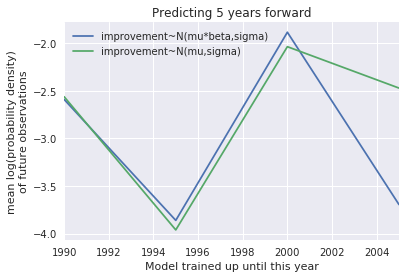

In [23]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


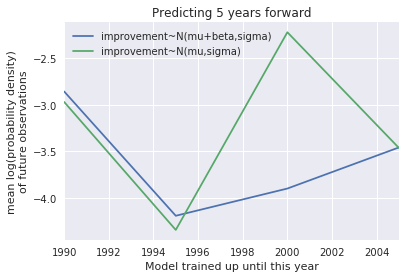

In [47]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


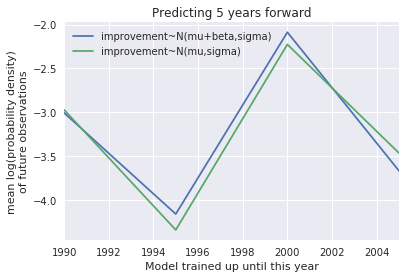

In [42]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


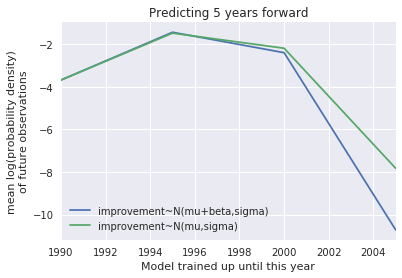

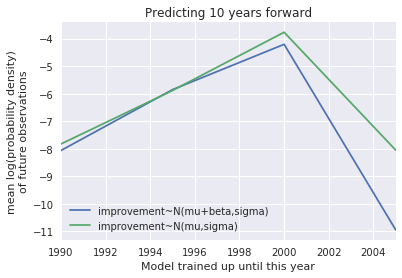

In [29]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


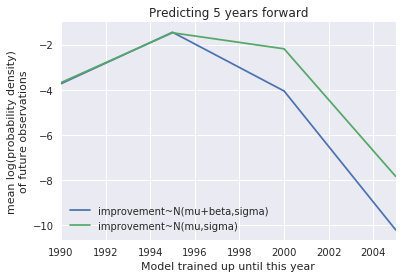

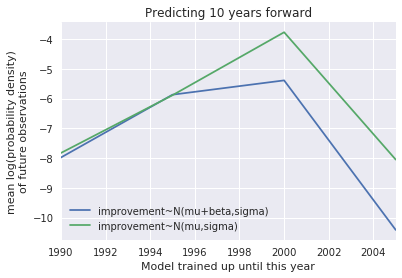

In [21]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


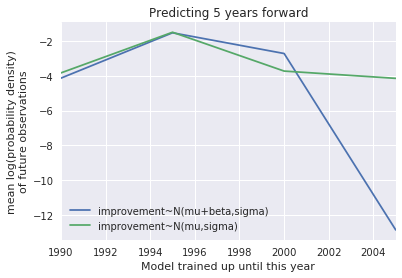

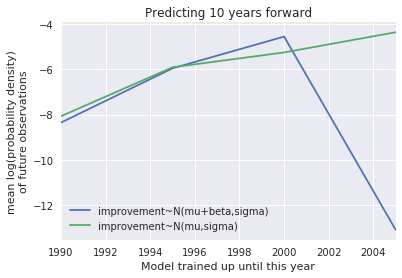

In [164]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


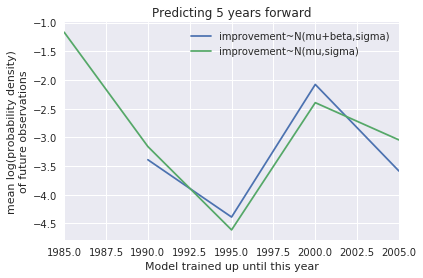

In [154]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


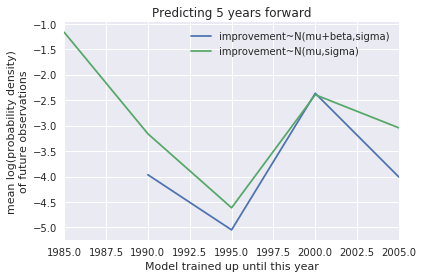

In [148]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Panel4D is deprecated and will be removed in a future version.
The recommended way to represent these types of n-dimensional data are with
the `xarray package <http://xarray.pydata.org/en/stable/>`__.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


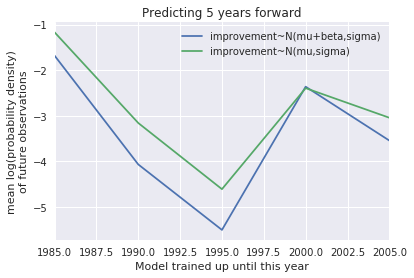

In [132]:
q = pd.Panel4D(performance_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    